# <p style="text-align: center;">Final Project - Malicious Webpage Identification</p>
### <p style="text-align: center;">University of Denver</p>
### <p style="text-align: center;">Alex Liddle</p>

### Motivation
As advancements in technology increase, so do cybersecurity threats. One step to countering these threats is to identify malicious webpages so they can be avoided. There are many algorithms in place to do this. This project is one more approach involving the use of semi supervised machine learning to quickly and accurately identify webpages that pose a threat.

In [1]:
import nltk
import string
import re
import sklearn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import the dataset

The dataset can be found on kaggle at https://www.kaggle.com/aksingh2411/dataset-of-malicious-and-benign-webpages. The dataset contains many columns consisting of attributes that include the url, results of the who_is command, javascript, and raw text content. Sites were labeled as either malicious or benign using the Google Safe Browsing API.

In [2]:
# Loade dataset into a pandas dataframe
df_reviews_raw = pd.read_csv('webpages.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
# Inspect for missing values
df_reviews_raw.isna().sum()

url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
dtype: int64

In [4]:
# Check data types
df_reviews_raw.dtypes

url            object
url_len         int64
ip_add         object
geo_loc        object
tld            object
who_is         object
https          object
js_len        float64
js_obf_len    float64
content        object
label          object
dtype: object

In [5]:
# Inspect a small sample
df_reviews_raw.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


### Clean the data

The data must be cleaned and transformed into a format that the machine learning algorithms further down in this notebook expect. Furthermore, there should be a uniform distribution of labels.

In [6]:
# Check the label distribution
df_reviews_raw.label.describe()

count     1200000
unique          2
top          good
freq      1172747
Name: label, dtype: object

In [7]:
# Get an equally distributed sample
df_reviews_untrimmed_sample = df_reviews_raw.groupby('label').apply(lambda x: x.sample(25000)).reset_index(drop=True)
# Remove if content has less than 60 words
df_reviews_trimmed = df_reviews_untrimmed_sample[df_reviews_untrimmed_sample.content.str.split().str.len().ge(60)]
df_reviews_trimmed.label.describe()

count     49323
unique        2
top         bad
freq      24963
Name: label, dtype: object

In [39]:
# Resample trimmed dataframe to make it uniformly distributed
df_reviews_sampled = df_reviews_trimmed.groupby('label').apply(lambda x: x.sample(2000)).reset_index(drop=True)
# Randomly shuffle rows for aesthetics
df_reviews = df_reviews_sampled.sample(frac=1).reset_index(drop=True)
df_reviews.label.describe()

count     4000
unique       2
top        bad
freq      2000
Name: label, dtype: object

### Examine the data

In [40]:
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.ashg.org/,20,136.242.100.106,United States,org,complete,yes,92.5,0.000,"Lionel messi, overthrow of ferdinand vii durin...",good
1,http://www.lara-uk.com/,23,115.27.204.145,China,com,incomplete,no,553.5,326.565,limey nigger's vulva fingerfucking xtc horsesh...,bad
2,http://www.geocities.com/televisioncity/statio...,72,56.73.49.49,United States,com,incomplete,no,0.0,0.000,liquor pissed moneyshot jacktheripper communis...,bad
3,http://www.fortunecity.com/roswell/streiber/27...,66,5.196.23.61,France,com,incomplete,yes,90.5,0.000,Inform personal consequences that. Of cultures...,good
4,http://www.svrpage.net/,23,186.121.242.190,Bolivia,net,incomplete,no,540.9,340.767,fucktard boom fuckers testicles dumb tinkle ho...,bad


In [41]:
df_reviews[['geo_loc', 'tld','who_is','https', 'label']].describe()

,geo_loc,tld,who_is,https,label
count,4000,4000,4000,4000,4000
unique,119,110,2,2,2
top,United States,com,incomplete,no,bad
freq,1720,2652,2187,2177,2000


### Text Preprocessing

To use our decision tree and random forest models, the data will need to be in a numerical format. As the value of one row with respect to another doesn't have an affect on either algorithm's decision when splitting a node (they are considered categorical variables), I will use ordinal encoding to transform the geo_loc, tld, who_is, https, and label columns. Meanwhile, natural language processing will be performed on the url and content columns.

In [42]:
df_reviews['geo_loc'] = OrdinalEncoder().fit_transform(df_reviews.geo_loc.values.reshape(-1,1))
df_reviews['tld'] = OrdinalEncoder().fit_transform(df_reviews.tld.values.reshape(-1,1))
df_reviews['who_is'] = OrdinalEncoder().fit_transform(df_reviews.who_is.values.reshape(-1,1))
df_reviews['https'] = OrdinalEncoder().fit_transform(df_reviews.https.values.reshape(-1,1))
df_reviews['label'] = OrdinalEncoder().fit_transform(df_reviews.label.values.reshape(-1,1))

# convert url into human readable string that can be tokenized
df_reviews['url'] = df_reviews.url.apply(lambda x: ' '.join(x.split('://')[1].strip('www.').replace('.','/').split('/')))
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,ashg org,20,136.242.100.106,114.0,86.0,0.0,1.0,92.5,0.000,"Lionel messi, overthrow of ferdinand vii durin...",1.0
1,lara-uk com,23,115.27.204.145,20.0,26.0,1.0,0.0,553.5,326.565,limey nigger's vulva fingerfucking xtc horsesh...,0.0
2,geocities com televisioncity station 3965 crus...,72,56.73.49.49,114.0,26.0,1.0,0.0,0.0,0.000,liquor pissed moneyshot jacktheripper communis...,0.0
3,fortunecity com roswell streiber 273 lucas_too...,66,5.196.23.61,34.0,26.0,1.0,1.0,90.5,0.000,Inform personal consequences that. Of cultures...,1.0
4,svrpage net,23,186.121.242.190,11.0,77.0,1.0,0.0,540.9,340.767,fucktard boom fuckers testicles dumb tinkle ho...,0.0


The textual data in the url and content columns will be tokenized, converted to lower case, and stopwords and punctuation will be removed.

In [43]:
print("Before Preprocessing:")
print(df_reviews.content.head(1))

tqdm.pandas()
stop = stopwords.words()

df_reviews.content = df_reviews.content.str.replace("[^\w\s]", "").str.lower()
df_reviews.content = df_reviews.content.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))
df_reviews.url = df_reviews.url.str.replace("[^\w\s]", "").str.lower()
df_reviews.url = df_reviews.url.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))

print("After Preprocessing:")
print(df_reviews.content.head(1))

Before Preprocessing:
0    Lionel messi, overthrow of ferdinand vii durin...
Name: content, dtype: object


100%|██████████| 4000/4000 [00:01<00:00, 2874.18it/s]

After Preprocessing:
0    lionel messi overthrow ferdinand vii late temp...
Name: content, dtype: object


### Label urls and content using tfidf vectorization and clustering

To convert the widely varying content of the url and content columns into something more manageable for the decision tree and random forest models, I will label them using mini batch kmeans clustering. First, however, I will convert them into numeric vectors. 

In [44]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df_reviews.url)
url_tfidf = tfidf.transform(df_reviews.url)

tfidf.fit(df_reviews.content)
content_tfidf = tfidf.transform(df_reviews.content)

I will use the elbow method to find the optimal number of clusters for each feature.

In [45]:
def find_optimal_clusters(data, max_k):
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
       
    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1)
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

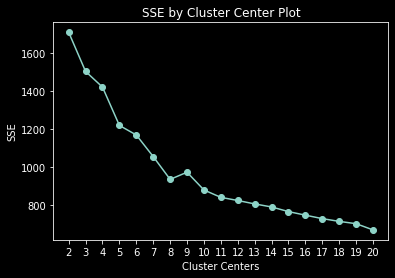

In [46]:
find_optimal_clusters(url_tfidf, 20)

An elbow can be seen where n_clusters equals eight. A new column, full of the clusters each row is assigned to, will be made.

In [59]:
df_reviews['url_cluster'] = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(url_tfidf)

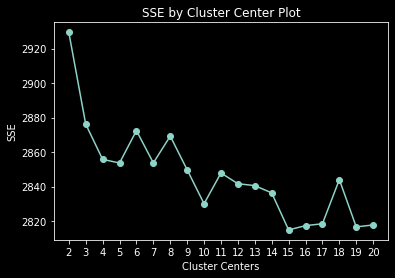

In [48]:
find_optimal_clusters(content_tfidf, 20)

An elbow can be seen where n_clusters equals four. A new column, full of the clusters each row is assigned to, will be made.

In [60]:
df_reviews['content_cluster'] = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(content_tfidf)

### Generate a training and test dataset

The cleaned, transformed dataset will be split into a training and test set using a 70%/30% split.

In [61]:
X = df_reviews[['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster',
                'js_len', 'js_obf_len']]
y = df_reviews.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model selection

For the decision tree, the "criterion" and "splitter" hyperparameters will be tuned and cross-validation will be performed using the GridSearchCV sklearn module.

In [62]:
# Decision Tree
param_grid=[{"criterion":["gini", "entropy"],
             "splitter":["best", "random"]}]
grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])

In [63]:
# Optimal hyperparameters
grid.best_params_

{'criterion': 'gini', 'splitter': 'best'}

Training and test accuracies are examined to determine if overfitting or underfitting has occurred.

In [64]:
# training accuracy
grid.score(X_train,y_train)

1.0

In [65]:
# test accuracy
grid.score(X_test,y_test)

0.9975

For the random forest, the "n_estimators" and "criterion" hyperparameters will be tuned and cross-validation will be performed using the GridSearchCV sklearn module.

In [66]:
# Random Forest
param_grid=[{"n_estimators":[x for x in range(10, 120, 10)],
             "criterion":["gini", "entropy"]}]
grid=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 110]}])

In [67]:
# Optimal hyperparameters
grid.best_params_

{'criterion': 'entropy', 'n_estimators': 90}

Training and test accuracies are examined to determine if overfitting or underfitting has occurred.

In [68]:
# training accuracy
grid.score(X_train,y_train)

1.0

In [69]:
# test accuracy
grid.score(X_test,y_test)

0.9983333333333333

### Conclusion

Both algorithms performed exceptionally well and there is no evidence of overfitting or underfitting. This project serves as validation for using unsupervised learning for labeling textual data and the decision tree and/or random forest algorithms for identifying malicious webpages.